# Porto's Taxis Data Analysis

### Imports

In [1]:
import ast
from datetime import timedelta

import geopandas as gpd
import hvplot.pandas
import matplotlib.pyplot as plt
import movingpandas as mpd
import numpy as np
import modin.pandas as pd
import seaborn as sns
import shapely as shp
from geopandas import GeoDataFrame
from movingpandas import TrajectoryCollection
from pandas import Timestamp

### Load Data

In [2]:
df = pd.read_csv("data/train.csv")

2025-05-16 20:16:00,644	INFO worker.py:1888 -- Started a local Ray instance.


(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 7ffa968db7ba8e5fe6cf48c345a8f2e4dc1b3d4c01000000 Worker ID: b956d5fa00966419d0c98a09fe8e39c990d8f89b5a1f51241784064c Node ID: 8669088c875fe5bc354fa683c977a2421a8a5728725413f9b575d4eb Worker IP address: 172.23.32.3 Worker port: 42003 Worker PID: 38769 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: bf8c5cd65e62906379274c96c96474561a9e011f01000000 Worker ID: 6d

KeyboardInterrupt: 

## Missing Values

In [ ]:
# How many rows have missing values?
df["MISSING_DATA"].value_counts()

MISSING_DATA
False    1710660
True          10
Name: count, dtype: int64

In [ ]:
# Remove rows with missing data
df = df[df["MISSING_DATA"] == False].drop(columns=["MISSING_DATA"])

### Sanity Check for the `ORIGIN_CALL` and `ORIGIN_STAND` Columns

In [ ]:
# There shouldn't be any rows with origin_call set that are not of type A
df[["ORIGIN_CALL", "CALL_TYPE"]].groupby("CALL_TYPE").count()

,ORIGIN_CALL
CALL_TYPE,
A,364769
B,0
C,0


In [ ]:
# There shouldn't be any rows with origin_stand set that are not of type B
df[["ORIGIN_STAND", "CALL_TYPE"]].groupby("CALL_TYPE").count()

,ORIGIN_STAND
CALL_TYPE,
A,0
B,806576
C,0


: 

## Preprocessing

In [ ]:
df = df.convert_dtypes()

df["TIMESTAMP"] = df["TIMESTAMP"].map(lambda x: Timestamp(x, unit="s", tz="Portugal"))
df["TIMESTAMP"] = df["TIMESTAMP"].dt.tz_convert("UTC").dt.tz_localize(None)

# df["TRIP_ID"] = df["TRIP_ID"].map(lambda x: int(x[1:]))

df["POLYLINE"] = df["POLYLINE"].map(ast.literal_eval)
df["LONGITUDE"] = df["POLYLINE"].map(lambda coords: [c[0] for c in coords])
df["LATITUDE"] = df["POLYLINE"].map(lambda coords: [c[1] for c in coords])
df["TIMESTAMP"] = df.apply(
    lambda row: [row["TIMESTAMP"] + timedelta(seconds=15 * i) for i in range(len(row["POLYLINE"]))], axis=1)

df["START"] = df["POLYLINE"].map(lambda coords: coords[0])
df["END"] = df["POLYLINE"].map(lambda coords: coords[-1])

exploded_df = df.drop(columns=["POLYLINE"]).copy()
exploded_df = df.explode(["LONGITUDE", "LATITUDE", "TIMESTAMP"])
exploded_df

## Analysis

### Taxis

In [ ]:
# How many taxis are there?
df["TAXI_ID"].nunique()

244

In [ ]:
# How many trips are we analysing?
df["TRIP_ID"].nunique()

320

In [ ]:
# Which rows have day type B?
df[df["DAY_TYPE"] == "B"]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE,LONGITUDE,LATITUDE,START,END


### Call Type Distribution

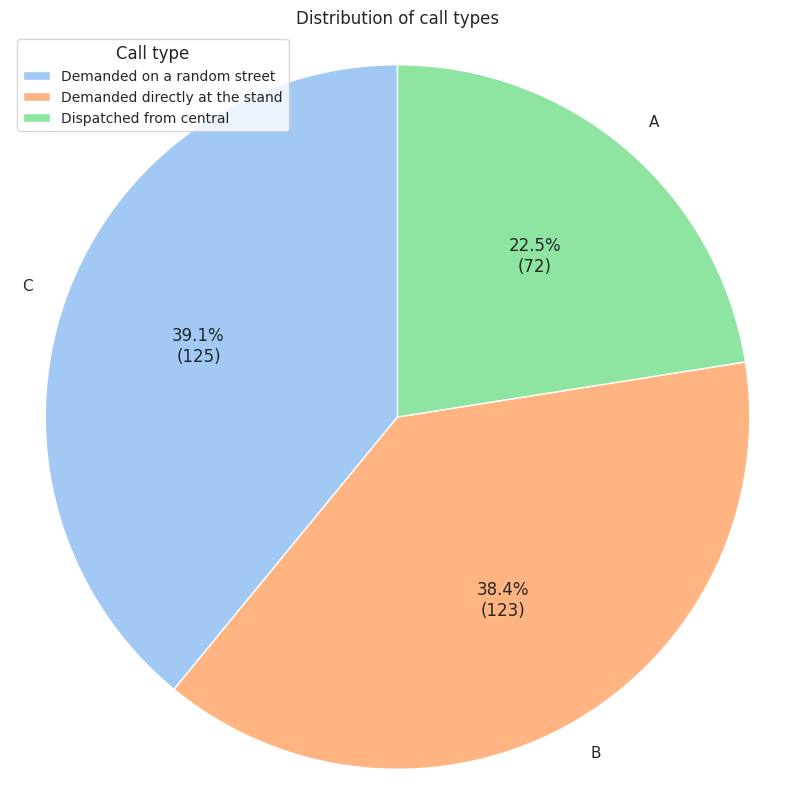

In [ ]:
calltype_meaning = {
    "A": "Dispatched from central",
    "B": "Demanded directly at the stand",
    "C": "Demanded on a random street"
}
sns.set_theme(style="whitegrid", palette="pastel", context="notebook")

calltype_counts = df["CALL_TYPE"].value_counts()

def autopct_format(pct):
    total = sum(calltype_counts)
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count:d})"

plt.figure(figsize=(10, 10))
plt.pie(
    calltype_counts,
    labels=calltype_counts.index, # type: ignore
    autopct=autopct_format,
    startangle=90,
)
plt.axis("equal")
plt.title("Distribution of call types")
plt.legend(
    loc="upper left",
    labels=[calltype_meaning[calltype] for calltype in df["CALL_TYPE"].value_counts().index],
    title="Call type",
    fontsize=10,
)
plt.show()

In [ ]:
# For `CALL_TYPE` 'B', which `ORIGIN_STAND`s are the most popular? Which are underutilized?

# Filter for CALL_TYPE 'B'
stands_b = df[df["CALL_TYPE"] == "B"]["ORIGIN_STAND"]

# Count occurrences of each stand
stand_counts = stands_b.value_counts()

# Show the top 10 most popular stands
print("Most popular ORIGIN_STANDs for CALL_TYPE 'B':")
print(stand_counts.head(10))

# Show the 10 least used stands (underutilized)
print("\nLeast used ORIGIN_STANDs for CALL_TYPE 'B':")
print(stand_counts.tail(10))

Most popular ORIGIN_STANDs for CALL_TYPE 'B':
ORIGIN_STAND
15    21
57    13
9      7
53     6
23     6
60     4
13     4
35     4
47     3
18     3
Name: count, dtype: Int64

Least used ORIGIN_STANDs for CALL_TYPE 'B':
ORIGIN_STAND
11    1
3     1
17    1
40    1
26    1
54    1
63    1
1     1
58    1
22    1
Name: count, dtype: Int64


In [ ]:
gdf = GeoDataFrame(exploded_df, geometry=gpd.points_from_xy(
    exploded_df["LONGITUDE"],
    exploded_df["LATITUDE"],
), crs="EPSG:4326")

gdf

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE,LONGITUDE,LATITUDE,START,END,geometry
0,1,B,<NA>,15,20000542,2014-08-14 17:57:17,A,"[[-8.585676, 41.148522], [-8.585712000000001, ...",-8.585676,41.148522,"[-8.585676, 41.148522]","[-8.584883999999999, 41.146623000000005]",POINT (-8.58568 41.14852)
0,1,B,<NA>,15,20000542,2014-08-14 17:57:32,A,"[[-8.585676, 41.148522], [-8.585712000000001, ...",-8.585712,41.148639,"[-8.585676, 41.148522]","[-8.584883999999999, 41.146623000000005]",POINT (-8.58571 41.14864)
0,1,B,<NA>,15,20000542,2014-08-14 17:57:47,A,"[[-8.585676, 41.148522], [-8.585712000000001, ...",-8.585685,41.148855,"[-8.585676, 41.148522]","[-8.584883999999999, 41.146623000000005]",POINT (-8.58569 41.14886)
0,1,B,<NA>,15,20000542,2014-08-14 17:58:02,A,"[[-8.585676, 41.148522], [-8.585712000000001, ...",-8.58573,41.148927,"[-8.585676, 41.148522]","[-8.584883999999999, 41.146623000000005]",POINT (-8.58573 41.14893)
0,1,B,<NA>,15,20000542,2014-08-14 17:58:17,A,"[[-8.585676, 41.148522], [-8.585712000000001, ...",-8.585982,41.148963,"[-8.585676, 41.148522]","[-8.584883999999999, 41.146623000000005]",POINT (-8.58598 41.14896)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,327,A,31208,<NA>,20000255,2014-12-21 14:28:45,A,"[[-8.574561000000001, 41.180184], [-8.572248, ...",-8.582562,41.199111,"[-8.574561000000001, 41.180184]","[-8.592345000000002, 41.192243999999995]",POINT (-8.58256 41.19911)
319,327,A,31208,<NA>,20000255,2014-12-21 14:29:00,A,"[[-8.574561000000001, 41.180184], [-8.572248, ...",-8.586135,41.19831,"[-8.574561000000001, 41.180184]","[-8.592345000000002, 41.192243999999995]",POINT (-8.58614 41.19831)
319,327,A,31208,<NA>,20000255,2014-12-21 14:29:15,A,"[[-8.574561000000001, 41.180184], [-8.572248, ...",-8.590464,41.197824,"[-8.574561000000001, 41.180184]","[-8.592345000000002, 41.192243999999995]",POINT (-8.59046 41.19782)
319,327,A,31208,<NA>,20000255,2014-12-21 14:29:30,A,"[[-8.574561000000001, 41.180184], [-8.572248, ...",-8.590779,41.195223,"[-8.574561000000001, 41.180184]","[-8.592345000000002, 41.192243999999995]",POINT (-8.59078 41.19522)


In [ ]:
collection = TrajectoryCollection(gdf, traj_id_col="TRIP_ID", t="TIMESTAMP")

In [ ]:
# collection.explore(tiles="CartoDB positron", cmap="plasma", column="CALL_TYPE")